In [59]:
import tensorflow as tf
from tensorflow.keras import models, layers 
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
import matplotlib.pyplot as plt
import numpy as np

In [60]:
IMAGE_SIZE = 300    # image resolution
BATCH_SIZE = 16     # batch size
CHANNELS = 3        # R-G-B channel


# training dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/train",      # directory
    shuffle = True,                                             # suffle the images
    image_size = (IMAGE_SIZE, IMAGE_SIZE),                      # image size
    batch_size = BATCH_SIZE                                     # batch size
)

# validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/val",
    shuffle = False,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

# test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/test",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


# class names denoted by the folder names
class_names = dataset.class_names
print(class_names)


# printing the size of the datasets
print(len(dataset))
print(len(val_dataset))
print(len(test_dataset))


# optimization purpose 
# caching 
# prefetching to simulataneously working of CPU and GPU
train_ds = dataset.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_dataset.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)


# resizing and rescaling images
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),                                         
    layers.experimental.preprocessing.Rescaling(1.0 / 255)                                         
])

Found 521 files belonging to 2 classes.
Found 64 files belonging to 2 classes.
Found 67 files belonging to 2 classes.
['AD', 'MCI']
33
4
5


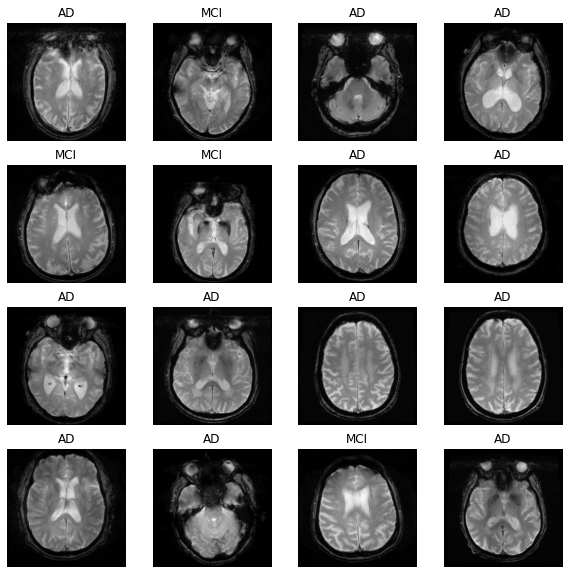

In [61]:
# printing the images
plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [62]:
# input shape with batch size, image size and channel
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# model 
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(2, padding='same'),          
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(2, padding='same'),    
    layers.Dropout(0.3),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(2, padding='same'),    
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')
])


# building the model
model.build(input_shape = input_shape)

In [63]:
model.summary()
# plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (16, 300, 300, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (16, 300, 300, 32)        896       
                                                                 
 batch_normalization_32 (Bat  (16, 300, 300, 32)       128       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (16, 300, 300, 32)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (16, 150, 150, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (16, 150, 150, 32)      

In [64]:
# compiling the model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy']
)

In [65]:
# defiging epochs
EPOCHS = 30


# recording the accuracy and loss data
history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
33/33 [==============================] - 4s 58ms/step - loss: 0.5581 - sparse_categorical_accuracy: 0.7083 - val_loss: 0.7575 - val_sparse_categorical_accuracy: 0.4219
Epoch 2/30
33/33 [==============================] - 2s 49ms/step - loss: 0.3140 - sparse_categorical_accuracy: 0.8772 - val_loss: 1.5162 - val_sparse_categorical_accuracy: 0.4219
Epoch 3/30
33/33 [==============================] - 2s 47ms/step - loss: 0.1620 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.5468 - val_sparse_categorical_accuracy: 0.5938
Epoch 4/30
33/33 [==============================] - 2s 50ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.5245 - val_sparse_categorical_accuracy: 0.6250
Epoch 5/30
33/33 [==============================] - 2s 52ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9923 - val_loss: 1.1386 - val_sparse_categorical_accuracy: 0.5781
Epoch 6/30
33/33 [==============================] - 2s 47ms/step - loss: 0.0368 - sparse_categorical_accu

In [66]:
# evaluating the model with test data
scores = model.evaluate(test_ds)

5/5 [==============================] - 0s 19ms/step - loss: 0.4908 - sparse_categorical_accuracy: 0.8806


In [67]:
scores

[0.49075597524642944, 0.8805969953536987]

In [68]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

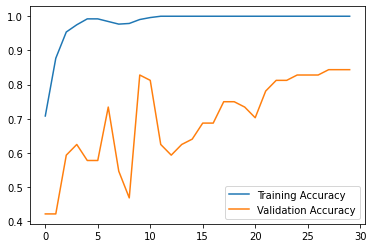

In [69]:
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend()
plt.show()

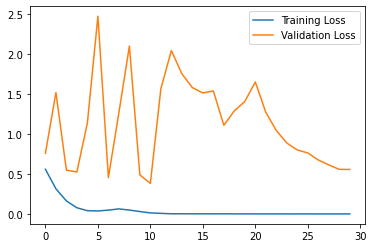

In [70]:
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend()
plt.show()

In [71]:
# predict function which returns confidence and class label
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)                    # expanding dimensions of the image array
    predictions = model.predict(img_array)                      # prediction
    predicted_class = class_names[np.argmax(predictions[0])]    # predicted class of the image 
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

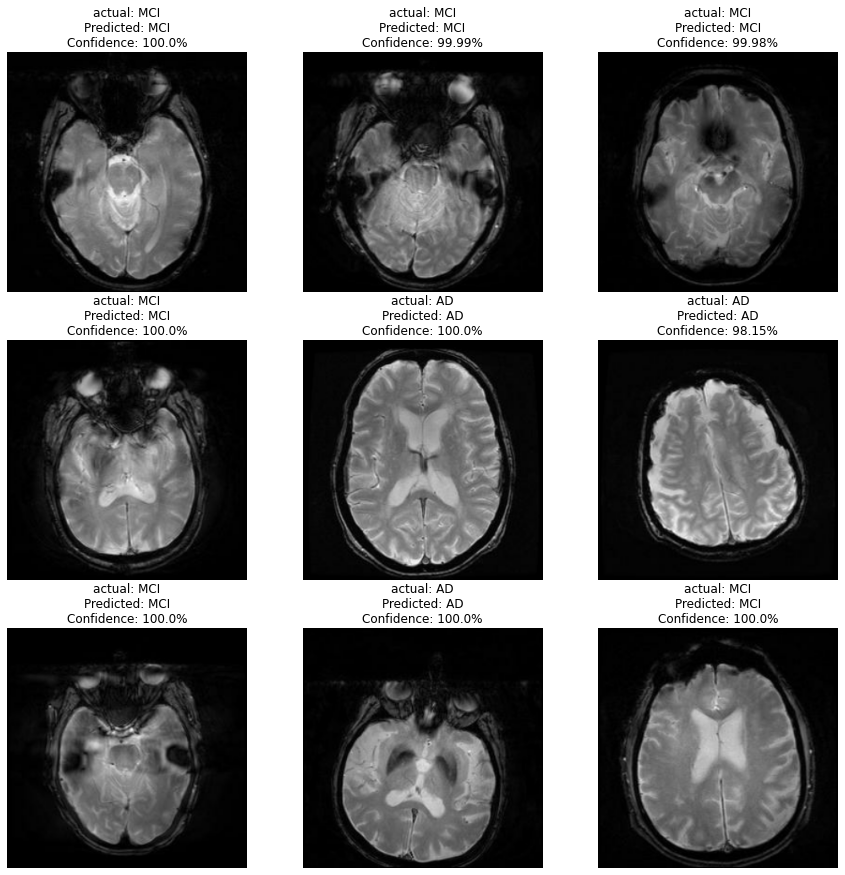

In [78]:
# testing the model with the test images
plt.figure(figsize=(15, 15))

for image_batch, label_batch in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, image_batch[i]) 
        actual_class = class_names[label_batch[i]]
        plt.title(f"actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

In [74]:
# saving the model
model.save(f"models/my_model.h5")